In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.io import loadmat
import glob, os
from shutil import copyfile, rmtree, unpack_archive
import math
from torch.utils.data import random_split

#get labels and substract 1 to get 0-based labels

image_labels = loadmat('/content/drive/MyDrive/ColabData/imagelabels.mat')['labels'][0]
image_labels -= 1

# get and devide to train,valid and test indices
setid = loadmat('/content/drive/MyDrive/ColabData/setid.mat')
idx_train = setid['trnid'][0] - 1
idx_test = setid['tstid'][0] - 1
idx_valid = setid['valid'][0] - 1

In [ ]:
unpack_archive("/content/drive/MyDrive/ColabData/102flowers.tgz", "/content/drive/MyDrive/ColabData/flowers/")


In [ ]:

# attach an image to ite corresponding label
files = sorted(glob.glob(os.path.join('/content/drive/MyDrive/ColabData/flowers', 'jpg', '*.jpg')))

labels = np.array([i for i in zip(files, image_labels)])

# get the cwd of the images
cwd = os.path.dirname(os.path.realpath('/content/drive/MyDrive/ColabData/flowers/jpg'))

train_set_size = int(len(image_labels) * 0.5)
valid_set_size = int((len(image_labels) - train_set_size)/2)
test_set_size = len(image_labels) - train_set_size - valid_set_size
train_set, valid_set, test_set = random_split(image_labels, [train_set_size, valid_set_size,test_set_size])

def move_files(dir_name, labels):
    '''

    Parameters
    ----------
    dir_name : the destination of the dir i.e train,valid or test.
    labels : the images and the corresponding labels

    Returns
    -------
    creates sub-dirs already sorted to train,test,valid. in each dear the classes are dirs, 
    containing the co-responding image

    '''
    cur_dir_path = os.path.join(cwd, dir_name)
    if not os.path.exists(cur_dir_path):
        os.mkdir(cur_dir_path)
        # print(cur_dir_path)

    for i in range(0, 102):
        class_dir = os.path.join(cwd, dir_name, str(i))
        if not os.path.exists(class_dir):
            os.mkdir(class_dir)
          # print(class_dir)

    for label in labels:
        src = str(label[0])
        dst = os.path.join(cwd, dir_name, label[1], src.split(os.sep)[-1])
        copyfile(src, dst)
        # print(label)
        # print(labels)
        # print(src,dst)      


move_files('train', labels[train_set.indices, :])
move_files('test', labels[test_set.indices, :])
move_files('valid', labels[valid_set.indices, :])

# create the sub-dirs : 
# move_files('train', labels[idx_train, :])
# move_files('test', labels[idx_test, :])
# move_files('valid', labels[idx_valid, :])


**PyTorch 102 flowers classification**


start with all neccessary imports

In [ ]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import time
import json
import copy
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

In [ ]:
train_dir = '/content/drive/MyDrive/ColabData/flowers/train'
valid_dir = '/content/drive/MyDrive/ColabData/flowers/valid'
test_dir = '/content/drive/MyDrive/ColabData/flowers/test'
data_dir = '/content/drive/MyDrive/ColabData/flowers/'

In [ ]:
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

In [ ]:
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

In [ ]:
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=8)
        for x in list(image_datasets.keys())
    }

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes = {
    x: len(dataloaders[x].dataset) for x in list(image_datasets.keys())
}
dataset_sizes

{'test': 2051, 'train': 4096, 'valid': 2049}

In [ ]:
class_names = image_datasets['train'].classes
class_names

lets view some images!

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


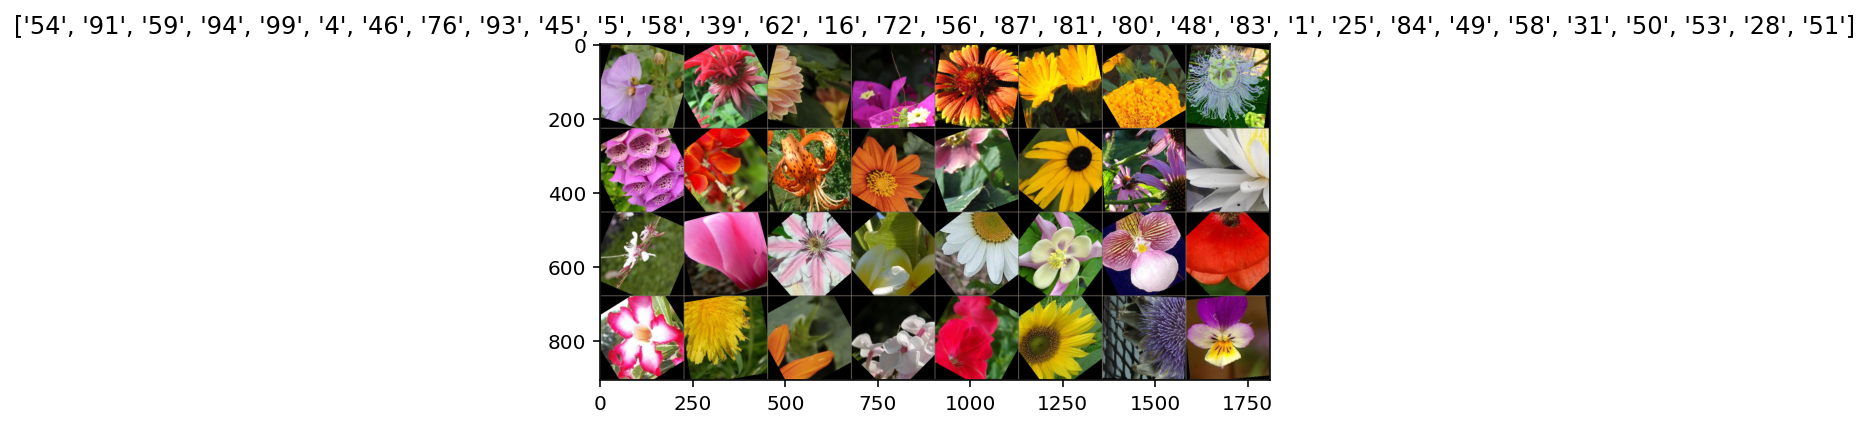

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
inputs.shape

torch.Size([32, 3, 224, 224])

In [ ]:
use_gpu = True

In [ ]:
#Based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    loss_list = {
        'train' : [],
        'valid' : []
    }
    acc_list = {
        'train' : [],
        'valid' : []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
  
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs,labels =  Variable(inputs.cuda()), Variable(labels.cuda())                    
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # zero the parameter gradients
                    optimizer.zero_grad()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'valid':
              loss_list['valid'].append(epoch_loss)
              acc_list['valid'].append(epoch_acc)
            else:
              loss_list['train'].append(epoch_loss)
              acc_list['train'].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # saving a checkpoint to use for next time to save time used in training from scratch
                # state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                #torch.save(state,'drive/flowers classification/point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,loss_list,acc_list

In [ ]:
def calc_accuracy(model,group = 'test'):
  n_correct = 0.0
  model.eval()
  for data in dataloaders[group]:
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model(inputs)
    _,preds = torch.max(outputs.data,1)
    n_correct += (preds == labels).sum().item()
  acc = n_correct / dataset_sizes[group]
  print('test_acc : {:4f}'.format(acc))



Now for a fine-tunning stage : 

In [ ]:
model_ft_2 = models.resnet34(pretrained=True)
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, 102)
if use_gpu:
  model_ft_2.cuda()
optimizer_ft_2 = torch.optim.SGD(params = model_ft_2.parameters(),lr = 0.001,momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model_2,loss_list_2,acc_list_2 = train_model(model_ft_2,criterion,optimizer_ft_2,num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.1226 Acc: 0.1885
valid Loss: 0.0856 Acc: 0.4070

Epoch 1/19
----------
train Loss: 0.0746 Acc: 0.5129
valid Loss: 0.0479 Acc: 0.6916

Epoch 2/19
----------
train Loss: 0.0499 Acc: 0.6824
valid Loss: 0.0309 Acc: 0.8204

Epoch 3/19
----------
train Loss: 0.0356 Acc: 0.7815
valid Loss: 0.0224 Acc: 0.8673

Epoch 4/19
----------
train Loss: 0.0280 Acc: 0.8257
valid Loss: 0.0172 Acc: 0.8907

Epoch 5/19
----------
train Loss: 0.0227 Acc: 0.8550
valid Loss: 0.0138 Acc: 0.9097

Epoch 6/19
----------
train Loss: 0.0192 Acc: 0.8748
valid Loss: 0.0119 Acc: 0.9258

Epoch 7/19
----------
train Loss: 0.0166 Acc: 0.8926
valid Loss: 0.0100 Acc: 0.9331

Epoch 8/19
----------
train Loss: 0.0147 Acc: 0.9014
valid Loss: 0.0092 Acc: 0.9366

Epoch 9/19
----------
train Loss: 0.0136 Acc: 0.9043
valid Loss: 0.0084 Acc: 0.9419

Epoch 10/19
----------
train Loss: 0.0123 Acc: 0.9214
valid Loss: 0.0071 Acc: 0.9483

Epoch 11/19
----------
train Loss: 0.0110 Acc: 0.9268
valid Loss: 0.0067 Acc: 0.9522



In [ ]:
calc_accuracy(model_2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test_acc : 0.968796


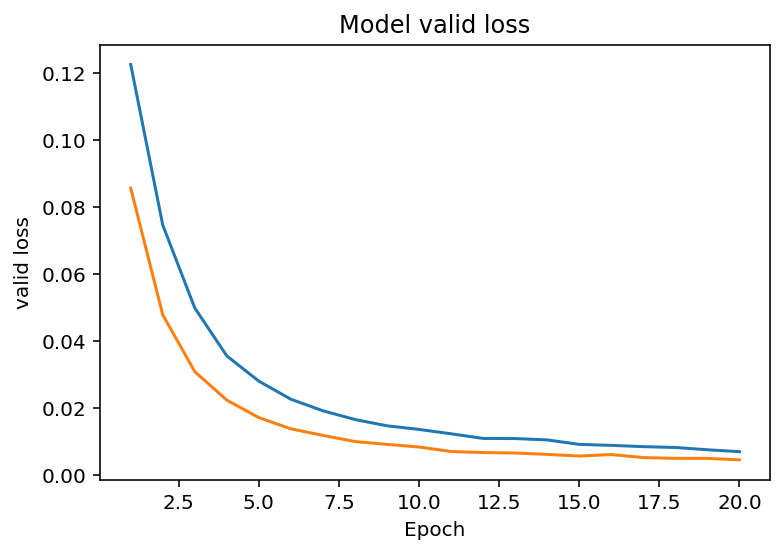

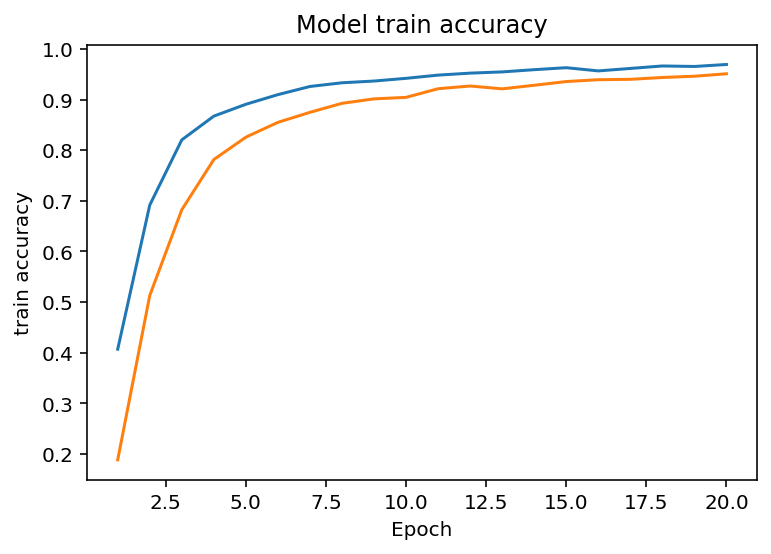

In [ ]:
loss_list_train = [i.item() for i in loss_list_2['train']]
acc_list_train = [i.item() for i in acc_list_2['train']]

loss_list_valid = [i.item() for i in loss_list_2['valid']]
acc_list_valid = [i.item() for i in acc_list_2['valid']]
plot_loss(loss_list_train,20,'train loss')
plot_loss(loss_list_valid,20,'valid loss')
plt.show()
plot_loss(acc_list_valid,20,'valid accuracy')
plot_loss(acc_list_train,20,'train accuracy')
plt.show()


In [ ]:
model_ft_3 = models.resnet50(pretrained=True)
num_ftrs = model_ft_3.fc.in_features
model_ft_3.fc = nn.Linear(num_ftrs, 102)
if use_gpu:
  model_ft_3.cuda()
optimizer_ft_3 = torch.optim.SGD(params = model_ft_3.parameters(),lr = 0.001,momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_3,loss_list_3,acc_list_3 = train_model(model_ft_3,criterion,optimizer_ft_3,num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.1263 Acc: 0.1689
valid Loss: 0.0973 Acc: 0.3343

Epoch 1/19
----------
train Loss: 0.0842 Acc: 0.4470
valid Loss: 0.0552 Acc: 0.5949

Epoch 2/19
----------
train Loss: 0.0557 Acc: 0.6348
valid Loss: 0.0355 Acc: 0.7696

Epoch 3/19
----------
train Loss: 0.0393 Acc: 0.7559
valid Loss: 0.0230 Acc: 0.8565

Epoch 4/19
----------
train Loss: 0.0291 Acc: 0.8315
valid Loss: 0.0183 Acc: 0.8809

Epoch 5/19
----------
train Loss: 0.0240 Acc: 0.8506
valid Loss: 0.0138 Acc: 0.9131

Epoch 6/19
----------
train Loss: 0.0195 Acc: 0.8787
valid Loss: 0.0109 Acc: 0.9253

Epoch 7/19
----------
train Loss: 0.0163 Acc: 0.8989
valid Loss: 0.0096 Acc: 0.9375

Epoch 8/19
----------
train Loss: 0.0140 Acc: 0.9124
valid Loss: 0.0082 Acc: 0.9419

Epoch 9/19
----------
train Loss: 0.0127 Acc: 0.9189
valid Loss: 0.0075 Acc: 0.9512

Epoch 10/19
----------
train Loss: 0.0117 Acc: 0.9236
valid Loss: 0.0072 Acc: 0.9497

Epoch 11/19
----------
train Loss: 0.0109 Acc: 0.9324
valid Loss: 0.0066 Acc: 0.9497



In [ ]:
calc_accuracy(model_3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test_acc : 0.973671


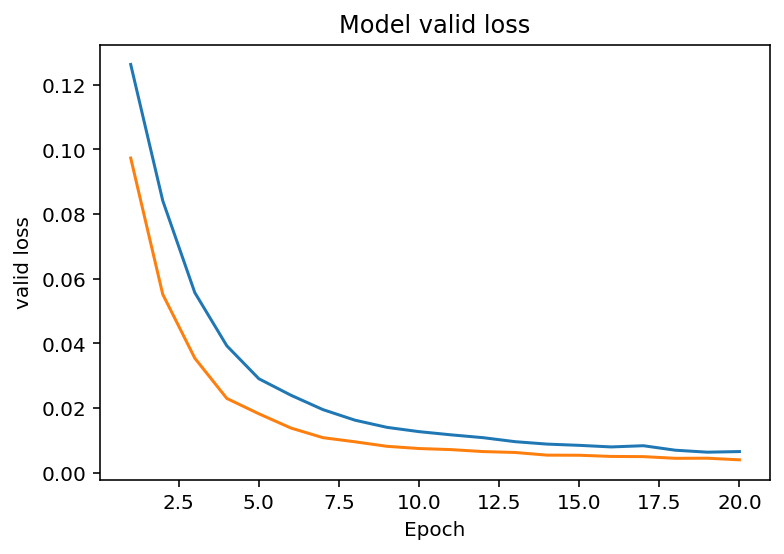

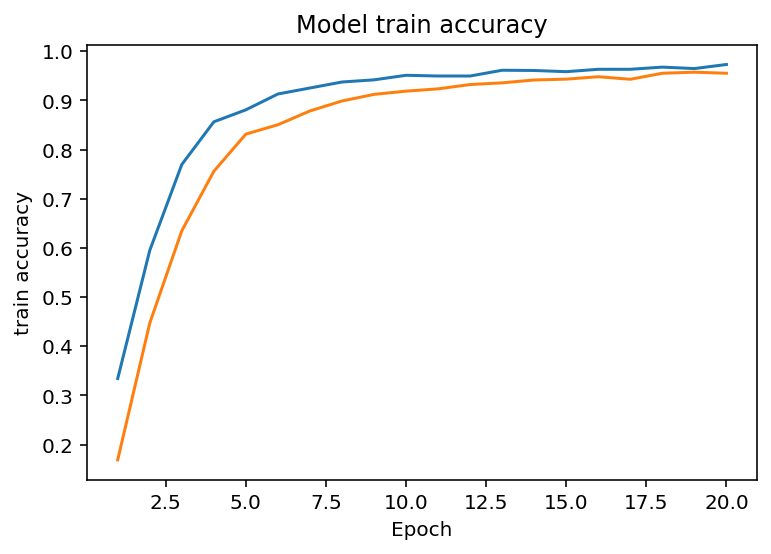

In [ ]:
loss_list_train = [i.item() for i in loss_list_3['train']]
acc_list_train = [i.item() for i in acc_list_3['train']]

loss_list_valid = [i.item() for i in loss_list_3['valid']]
acc_list_valid = [i.item() for i in acc_list_3['valid']]
plot_loss(loss_list_train,20,'train loss')
plot_loss(loss_list_valid,20,'valid loss')
plt.show()
plot_loss(acc_list_valid,20,'valid accuracy')
plot_loss(acc_list_train,20,'train accuracy')
plt.show()